In [61]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, classification_report
from joblib import dump, load
pd.set_option('mode.chained_assignment', None)

In [62]:
first_season = 2012
last_season = 2023

save_models = True

season_file = f'{first_season}-{last_season}'

min_threshold = 1.75
max_threshold = 10

first_attr_index = 6
target_index = -3

# default_stake = 50
bankroll = 2000
stake = 0.025

In [63]:
print('\nGetting data for the model...')

dataset = pd.read_csv('./data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date


Getting data for the model...


In [64]:
dataset

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
0,2012,2012-11-17,PHX,MIA,3.20,1.36,99.3,105.0,0.4307,0.3241,...,1.0,0.500000,-1,0.7,0.6,111.655660,107.418542,A,88,97
1,2012,2012-11-18,DET,BOS,2.46,1.56,93.0,99.8,0.4378,0.3553,...,0.0,0.600000,-1,0.6,0.6,105.807366,104.982441,H,103,83
2,2012,2012-11-19,DAL,GSW,1.16,5.34,100.9,100.1,0.4627,0.3893,...,0.0,0.500000,-1,0.5,0.4,100.099647,102.401857,A,101,105
3,2012,2012-11-19,UTA,HOU,1.33,3.37,96.2,97.8,0.4370,0.3231,...,0.0,0.400000,-2,0.4,0.4,102.150776,102.700599,H,102,91
4,2012,2012-11-20,PHI,TOR,1.45,2.77,88.9,90.1,0.4109,0.4000,...,0.0,0.200000,-1,0.3,0.2,100.874199,104.481087,H,106,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11963,2023,2024-01-21,PHX,IND,1.38,3.11,117.8,113.3,0.5047,0.3771,...,0.4,0.523810,-1,0.6,0.4,117.560759,115.483577,H,117,110
11964,2023,2024-01-21,LAL,POR,1.17,5.25,114.1,120.4,0.4953,0.3582,...,0.4,0.227273,-2,0.3,0.2,99.323529,118.428491,H,134,110
11965,2023,2024-01-22,DET,MIL,1.38,3.11,119.3,128.9,0.4906,0.3957,...,0.9,0.526316,-1,0.5,0.4,119.085533,121.521600,A,113,122
11966,2023,2024-01-22,ORL,CLE,2.12,1.75,107.8,110.3,0.4531,0.3583,...,0.7,0.588235,-7,0.8,0.6,117.749453,103.199365,A,99,126


In [65]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,REB_A,TOV_A,SEASON_A_PCT,PER_A,ELO_A,...,ELO_B,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,GAME_PTS_A,GAME_PTS_B
PTS_A,1.000000,0.672603,0.657007,0.384231,0.294310,0.277803,-0.170936,0.332526,0.681368,0.351910,...,0.013253,-0.053016,0.023277,0.025994,0.006879,0.038842,0.389372,0.422392,0.471041,0.351087
PTS_CON_A,0.672603,1.000000,0.210944,0.021529,0.132481,0.041530,-0.001456,-0.276243,0.279175,-0.290732,...,0.031963,0.119667,0.027784,0.019162,0.019890,0.039963,0.398921,0.416713,0.343233,0.456252
FG_PCT_A,0.657007,0.210944,1.000000,0.518807,0.181578,-0.092355,-0.077002,0.444806,0.577797,0.455607,...,-0.014801,-0.104546,-0.009497,0.012781,-0.008236,0.010774,0.190507,0.215919,0.266121,0.112552
FG3_PCT_A,0.384231,0.021529,0.518807,1.000000,0.175493,-0.093377,-0.094070,0.327547,0.346673,0.351996,...,-0.028161,-0.121964,-0.007431,0.006884,-0.016724,-0.003379,0.036061,0.064377,0.120767,-0.002034
FT_PCT_A,0.294310,0.132481,0.181578,0.175493,1.000000,-0.072348,-0.170166,0.173380,0.238973,0.189310,...,0.013851,-0.044287,0.020188,0.007538,0.007039,0.016205,0.135691,0.147738,0.132400,0.064678
REB_A,0.277803,0.041530,-0.092355,-0.093377,-0.072348,1.000000,0.116513,0.206070,0.191367,0.212104,...,0.015667,-0.004310,0.023644,0.005739,0.002443,0.018503,0.070045,0.073170,0.156676,0.078337
TOV_A,-0.170936,-0.001456,-0.077002,-0.094070,-0.170166,0.116513,1.000000,-0.165807,-0.196327,-0.206163,...,0.011163,0.043688,-0.010803,-0.006293,0.010698,-0.011552,-0.091116,-0.117779,-0.073840,-0.009712
SEASON_A_PCT,0.332526,-0.276243,0.444806,0.327547,0.173380,0.206070,-0.165807,1.000000,0.428556,0.863754,...,-0.018603,-0.280628,-0.002191,0.005126,-0.003837,0.007198,0.007040,0.007045,0.177258,-0.132279
PER_A,0.681368,0.279175,0.577797,0.346673,0.238973,0.191367,-0.196327,0.428556,1.000000,0.448877,...,0.013672,-0.110256,0.023537,0.018840,0.004512,0.028905,0.240327,0.245310,0.344339,0.162499
ELO_A,0.351910,-0.290732,0.455607,0.351996,0.189310,0.212104,-0.206163,0.863754,0.448877,1.000000,...,-0.028491,-0.316926,-0.002602,0.002119,-0.009983,0.006705,0.006404,0.017032,0.184919,-0.138482


In [66]:
def create_file(directory, file, file_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
            
    dump(file, f'{directory}/{file_name}.joblib')

def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        create_file('models', classifier, model_abbv)
    
#     print(classification_report(y_test, predictions))
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
#     display(test_dataset)
    
    return results_df

In [67]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('RF', rf_classifier),
            ('GB', gb_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF_1000'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=800), 'abbreviation': 'KNN'},
        {'classifier': SGDClassifier(loss="log", random_state = 0), 'abbreviation': 'SGD'}, 
        {'classifier': LogisticRegression(), 'abbreviation': 'LR'}
    ]
    
    columns = dataset.columns[first_attr_index:target_index-1]
    target_col = dataset.columns[target_index]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        create_file('scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2023/2023 - LR


In [68]:
min_odds = 1.8

def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1/(row[f"{model_abbv}_PROBS_A" if row[f"{model_abbv}_PRED"] == "H" else f"{model_abbv}_PROBS_B"])
    
    bet_valid = odds > min_odds and pred_odds < odds
    
    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0
    
display(main_df)

in_depth_models_for_analysis = ['RF_1000', 'GB', 'SVM', 'VC']

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=['Season'])
    
for model in models:
    model_abbv = model["abbreviation"]
    
    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(lambda x: create_game_profit_col(x, model_abbv), axis=1)
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (main_df[f"{model_abbv}_PRED"] == main_df['WINNER']).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")
    
    if model_abbv not in in_depth_models_for_analysis:
        continue
    
    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby('SEASON_ID').agg({
        f'{model_abbv}_PROFIT_TRACKING': lambda x: x.iloc[-1] - x.iloc[0],
        f'{model_abbv}_PROFIT': lambda x: (x != 0).sum(),  # Counting only non-zero profits as bets
    })

    # Rename columns for clarity
    model_season_stats.columns = [f'{model_abbv}_Net_Gains', f'{model_abbv}_Total_Bets']

    # Calculate additional statistics
    model_season_stats[f'{model_abbv}_Yield'] = (model_season_stats[f'{model_abbv}_Net_Gains'] / model_season_stats[f'{model_abbv}_Total_Bets']) * 100
    
    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(season_stats, model_season_stats, left_on='Season', right_index=True, how='outer')
    
season_stats.drop('Season', axis=1, inplace=True)


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,NB_PROBS_B,KNN_PRED,KNN_PROBS_A,KNN_PROBS_B,SGD_PRED,SGD_PROBS_A,SGD_PROBS_B,LR_PRED,LR_PROBS_A,LR_PROBS_B
0,2013,2013-11-16,MIN,BOS,1.18,5.03,108.7,101.4,0.4437,0.3571,...,0.002318,H,0.67125,0.32875,H,0.988513,0.011487,H,0.895987,0.104013
1,2013,2013-11-18,DAL,PHI,1.10,7.27,106.6,103.6,0.4708,0.3986,...,0.000366,H,0.67250,0.32750,H,0.998877,0.001123,H,0.923742,0.076258
2,2013,2013-11-18,UTA,GSW,4.07,1.25,87.8,100.2,0.4119,0.2684,...,0.999824,H,0.54875,0.45125,A,0.387071,0.612929,A,0.330774,0.669226
3,2013,2013-11-18,LAC,MEM,1.24,4.16,110.0,105.7,0.4880,0.3362,...,0.000563,H,0.66125,0.33875,H,0.946323,0.053677,H,0.820348,0.179652
4,2013,2013-11-19,MIA,ATL,1.21,4.44,106.1,98.6,0.5251,0.4412,...,0.000400,H,0.64125,0.35875,H,0.993874,0.006126,H,0.833645,0.166355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10891,2023,2024-01-21,PHX,IND,1.38,3.11,117.8,113.3,0.5047,0.3771,...,0.251407,H,0.58875,0.41125,H,0.549759,0.450241,H,0.669376,0.330624
10892,2023,2024-01-21,LAL,POR,1.17,5.25,114.1,120.4,0.4953,0.3582,...,0.002851,H,0.74375,0.25625,H,0.694279,0.305721,H,0.823873,0.176127
10893,2023,2024-01-22,DET,MIL,1.38,3.11,119.3,128.9,0.4906,0.3957,...,0.999941,A,0.37750,0.62250,A,0.089962,0.910038,A,0.126839,0.873161
10894,2023,2024-01-22,ORL,CLE,2.12,1.75,107.8,110.3,0.4531,0.3583,...,0.982860,A,0.45500,0.54500,A,0.327942,0.672058,A,0.437615,0.562385



RF_1000 Net Gains: 172.9399999999998
RF_1000 Yield: 1.59%
RF_1000 Strike Rate: 65.89%

GB Net Gains: 193.79999999999973
GB Yield: 1.78%
GB Strike Rate: 65.64%

SVM Net Gains: 122.5599999999998
SVM Yield: 1.12%
SVM Strike Rate: 65.35%

VC Net Gains: 156.06999999999974
VC Yield: 1.43%
VC Strike Rate: 65.87%

NB Net Gains: 108.20000000000005
NB Yield: 0.99%
NB Strike Rate: 64.85%

KNN Net Gains: 84.04000000000022
KNN Yield: 0.77%
KNN Strike Rate: 64.79%

SGD Net Gains: 40.899999999999935
SGD Yield: 0.38%
SGD Strike Rate: 63.68%

LR Net Gains: 127.92000000000013
LR Yield: 1.17%
LR Strike Rate: 66.07%


In [69]:
display(season_stats)

,RF_1000_Net_Gains,RF_1000_Total_Bets,RF_1000_Yield,GB_Net_Gains,GB_Total_Bets,GB_Yield,SVM_Net_Gains,SVM_Total_Bets,SVM_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield
SEASON_ID,,,,,,,,,,,,
2013,-13.30,219,-6.073059,9.28,271,3.424354,-8.36,236,-3.542373,-13.97,245,-5.702041
2014,28.78,189,15.227513,47.37,259,18.289575,18.06,205,8.809756,33.30,223,14.932735
2015,26.28,210,12.514286,6.66,215,3.097674,44.35,208,21.322115,16.79,208,8.072115
2016,37.15,204,18.210784,20.38,219,9.305936,42.18,240,17.575000,31.31,204,15.348039
2017,19.43,202,9.618812,25.65,198,12.954545,0.48,228,0.210526,16.17,199,8.125628
2018,30.32,207,14.647343,2.50,226,1.106195,9.52,232,4.103448,16.79,210,7.995238
2019,37.42,203,18.433498,24.98,208,12.009615,12.93,210,6.157143,28.30,211,13.412322
2020,9.71,201,4.830846,17.22,206,8.359223,26.24,213,12.319249,6.72,205,3.278049
2021,4.51,193,2.336788,9.44,193,4.891192,-26.34,195,-13.507692,7.52,188,4.000000


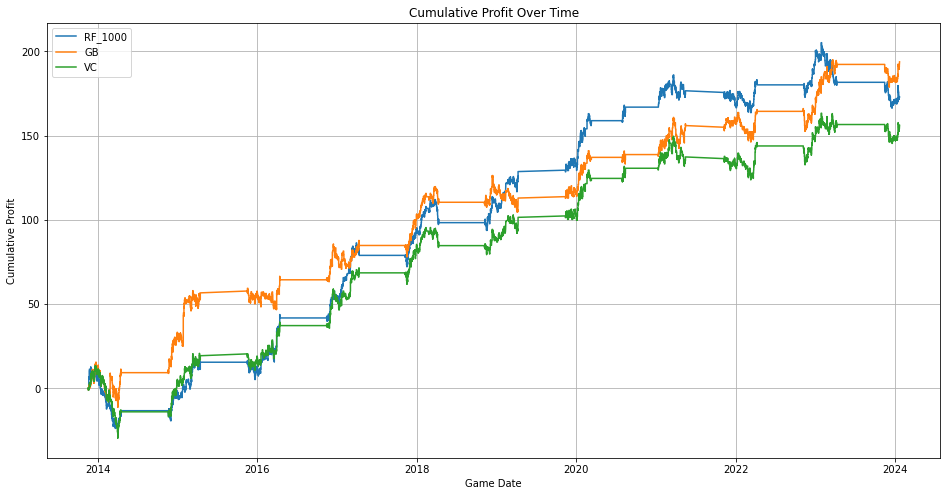

In [72]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv == 'RF_1000' or model_abbv == 'GB' or model_abbv == 'VC':
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 